In [2]:
!pip install -q efficientnet
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201  # Changed from EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [3]:
# Cấu hình
original_dir = "/kaggle/input/rice-leaf-disease-image"  # Đường dẫn chứa dữ liệu gốc
output_dir = "dataset"                                    # Thư mục mới chứa tập train_val và test
test_split = 0.2                                         # Tỉ lệ test
IMAGE_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
random.seed(42)  # Đảm bảo reproducibility

# Tách dữ liệu thành train_val và test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lặp qua từng lớp
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Tạo thư mục lớp trong train_val và test
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Lấy danh sách ảnh, shuffle
    images = os.listdir(class_path)
    random.shuffle(images)

    # Tách
    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]

    # Di chuyển ảnh vào đúng nơi
    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(train_val_dir, class_name, img)
        )

print("✅ Đã tách dữ liệu thành công.")

Copying train_val images for Brownspot: 100%|██████████| 1280/1280 [00:05<00:00, 222.41it/s]

✅ Đã tách dữ liệu thành công.


In [4]:
# Kiểm tra cấu trúc dữ liệu
for root, dirs, files in os.walk(output_dir):
    print(root, ":", len(files), "files")

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo generator cho tập train
train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Tạo generator cho tập validation
val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Tạo generator cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Số lượng lớp
NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())

print(f"Số lớp: {NUM_CLASSES}")
print(f"Số lượng ảnh train: {train_generator.samples}")
print(f"Số lượng ảnh validation: {val_generator.samples}")
print(f"Số lượng ảnh test: {test_generator.samples}")

dataset : 0 files
dataset/train_val : 0 files
dataset/train_val/Brownspot : 1280 files
dataset/train_val/Blast : 1152 files
dataset/train_val/Tungro : 1047 files
dataset/train_val/Bacterialblight : 1268 files
dataset/test : 0 files
dataset/test/Brownspot : 320 files
dataset/test/Blast : 288 files
dataset/test/Tungro : 261 files
dataset/test/Bacterialblight : 316 files
Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Số lớp: 4
Số lượng ảnh train: 3799
Số lượng ảnh validation: 948
Số lượng ảnh test: 1185


In [7]:
# Hàm tạo model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Fine-tuning: Mở khóa 20 lớp cuối
for layer in densenet_base.layers[:-20]:
    layer.trainable = False
for layer in densenet_base.layers[-20:]:
    layer.trainable = True

densenet_model = build_model(densenet_base)
densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("densenet201_rice_leaf_best.h5", monitor='val_loss', save_best_only=True, mode='min')

In [8]:
# Huấn luyện mô hình
densenet_history = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Đánh giá mô hình trên tập validation
val_loss, val_acc = densenet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Đánh giá mô hình trên tập test
test_loss, test_acc = densenet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748791868.001288     127 service.cc:148] XLA service 0x7fb4fc004890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748791868.002340     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748791872.785583     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:02:52 64s/step - accuracy: 0.1875 - loss: 1.9666

I0000 00:00:1748791896.768646     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.4912 - loss: 1.1926 - val_accuracy: 0.8745 - val_loss: 0.4451 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 893ms/step - accuracy: 0.9193 - loss: 0.2998 - val_accuracy: 0.9789 - val_loss: 0.1717 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 904ms/step - accuracy: 0.9821 - loss: 0.1100 - val_accuracy: 0.9937 - val_loss: 0.0651 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 897ms/step - accuracy: 0.9946 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.0287 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 905ms/step - accuracy: 0.9984 - loss: 0.0230 - val_accuracy: 0.9989 - val_loss: 0.0159 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 898ms/step - accuracy: 0.9989 - loss: 0.0168 - val_accuracy: 0.9989 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 894ms/step - accuracy: 1.0000

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       316
          Blast       1.00      1.00      1.00       288
      Brownspot       1.00      1.00      1.00       320
         Tungro       1.00      1.00      1.00       261

       accuracy                           1.00      1185
      macro avg       1.00      1.00      1.00      1185
   weighted avg       1.00      1.00      1.00      1185



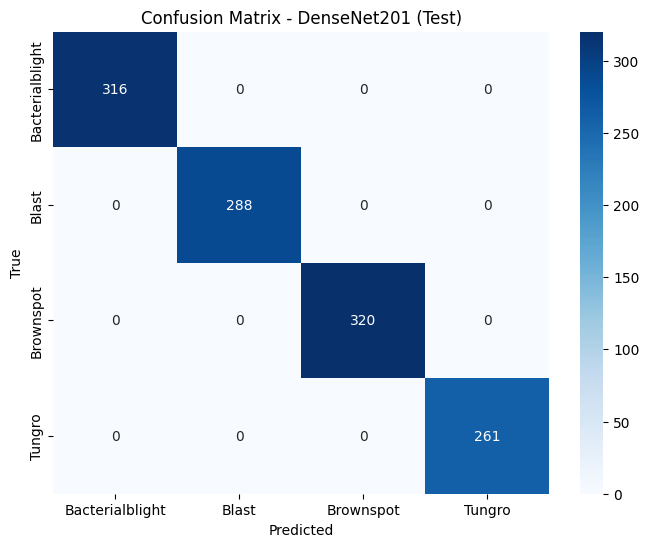

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step
Validation Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       253
          Blast       1.00      1.00      1.00       230
      Brownspot       1.00      1.00      1.00       256
         Tungro       1.00      1.00      1.00       209

       accuracy                           1.00       948
      macro avg       1.00      1.00      1.00       948
   weighted avg       1.00      1.00      1.00       948



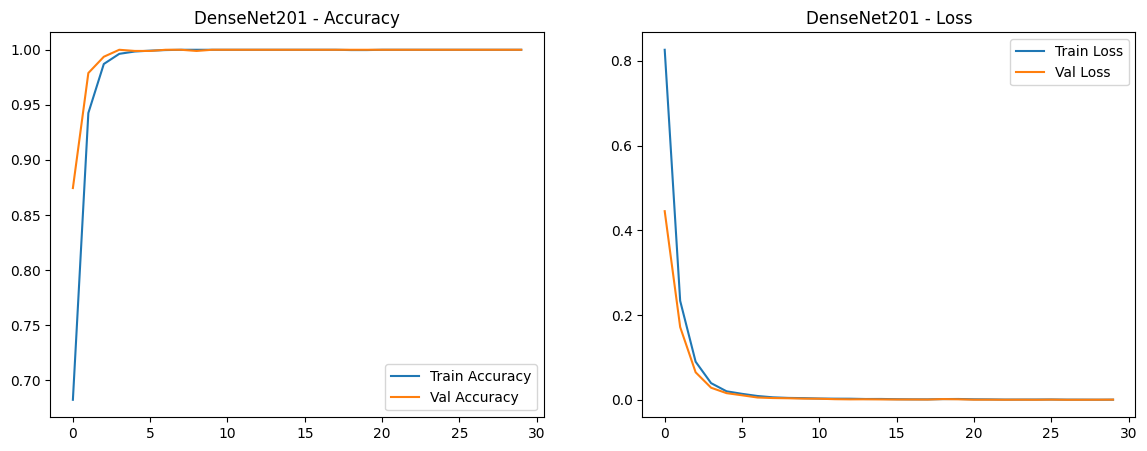

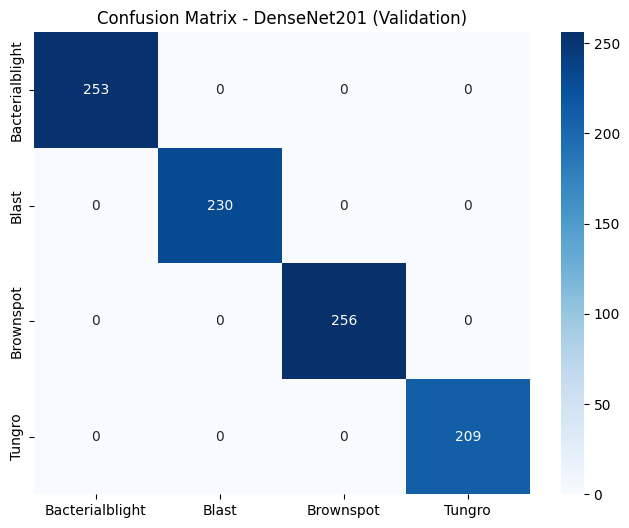

In [11]:


# Phần đánh giá mô hình trên tập test (detailed)
test_generator.reset()  # Reset để đảm bảo thứ tự
test_preds = densenet_model.predict(test_generator)  # Updated to use densenet_model
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

# Báo cáo phân loại cho tập test
print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn cho tập test
test_conf_mat = confusion_matrix(test_y_true, test_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - DenseNet201 (Test)")  # Updated title to reflect DenseNet201
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix_test.png')
plt.show()

# Hàm vẽ biểu đồ lịch sử huấn luyện
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.savefig('training_history.png')

plot_history(densenet_history, "DenseNet201")

# Đánh giá mô hình DenseNet201 trên tập validation
val_generator.reset()
densenet_preds = densenet_model.predict(val_generator)
densenet_y_pred = np.argmax(densenet_preds, axis=1)
densenet_y_true = val_generator.classes

# Báo cáo phân loại
print("Validation Classification Report:")
print(classification_report(densenet_y_true, densenet_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn
densenet_conf_mat = confusion_matrix(densenet_y_true, densenet_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(densenet_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - DenseNet201 (Validation)")
plt.savefig('confusion_matrix.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Test image path: dataset/test/Blast/BLAST3_112.jpg
True class: Blast
Predicted class: Blast
Confidence: 0.9997


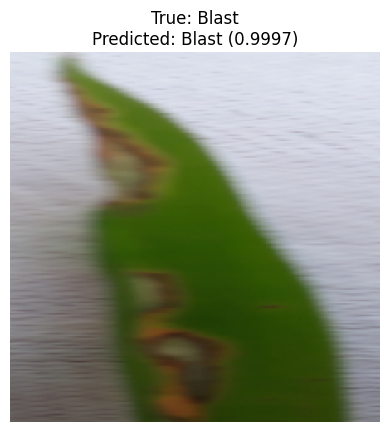

In [12]:
# Phần test ảnh ngẫu nhiên từ tập test
# Tải mô hình đã huấn luyện
model = tf.keras.models.load_model('densenet201_rice_leaf_best.h5')

# Lấy danh sách tất cả ảnh trong tập test
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

# Chọn ngẫu nhiên một ảnh
test_img_path = random.choice(image_paths)

# Tải và xử lý ảnh test
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img) / 255.0  # Chuẩn hóa ảnh
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

# Dự đoán lớp
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Lấy nhãn thật từ đường dẫn
true_class = os.path.basename(os.path.dirname(test_img_path))

# Hiển thị kết quả
print(f"Test image path: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Hiển thị ảnh test
plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('test_result.png')

# Lưu mô hình
densenet_model.save("densenet201_rice_final.h5")